## CREATION OF HULLS

#### GS HULLS

In [1]:
# GS HULLS

import json 

hull_gs = {}

with open('ENTHALPY/EntGS.json') as f:
    ent_gs_dict = json.load(f)
with open('ENTHALPY/OneEl.json') as f:
    one_el = json.load(f)

test_elements = ['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na', 'Si', 'S', 'Cl', 'F', 'P', 'H', 'Al']

complist = [1,2,3,4,6]

for comp in complist:
    hull_gs[comp] = {}
    if comp == 1:
        for i in range(len(test_elements)):
            for j in range(i+1, len(test_elements)):
                pair_as_list = [test_elements[i], test_elements[j]]
                pair_as_list.sort()
                A = pair_as_list[0]
                B = pair_as_list[1]
                pair = A + B
                entA = one_el[A]
                entB = one_el[B]

                ent_gs = ent_gs_dict[f'{comp}'][pair] - (entA*comp + entB)/(comp+1)

                hull_gs[comp][pair] = ent_gs
    else:
        for A in test_elements:
            for B in test_elements:
                if A == B:
                    continue
                pair = A + B

                entA = one_el[A]
                entB = one_el[B]
                ent_gs = ent_gs_dict[f'{comp}'][pair] - (entA*comp + entB)/(comp+1)

                hull_gs[comp][pair] = ent_gs
    
    with open('ConvexHulls_GS.json', 'w') as f:
        json.dump(hull_gs, f, indent=4)    

### REARRANGE THE DATA
gs_hulls = {}


with open('ConvexHulls_GS.json') as f:
    old_gs = json.load(f)

complist = [1,2,3,4,6]

for i in range(len(test_elements)):
    for j in range(i+1, len(test_elements)):
        pair_as_list = [test_elements[i], test_elements[j]]
        pair_as_list.sort()
        A = pair_as_list[0]
        B = pair_as_list[1]
        gs = []

        for comp in complist:

            ent_gs = old_gs[f'{comp}'][A+B]
            gs.insert(0, ent_gs)
            if comp != 1:

                ent_gs = old_gs[f'{comp}'][B+A]
                gs.append(ent_gs)

        gs_hulls[A+B] = gs

with open('ConvexHulls_GS.json', 'w') as f:
    json.dump(gs_hulls, f, indent=4)




#### TEMP HULLS

In [3]:
### SINGLE RUN OF THE TEMPLATE GENERATION

import template_csp.managetemp_withdict as mt
import json
import numpy as np
test_elements = ['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na', 'Si', 'S', 'Cl', 'F', 'P', 'H', 'Al']

hyperparameters = { 
    "weight_occurrence" : 1,
    "weight_sg" : 0.001,
    "weight_formation_entalphy" : 1, 

    "comp" : 1,

    "n_final_templates" : 1
}

hull_dict = {}
hull_dict_gs = {}


complist = [1,2,3,4,6]
final_size = [10,20,15,15,10]
initial_size = [20,45,30,30, 20]

with open('ENTHALPY/EntGS.json') as f:
    ent_gs_dict = json.load(f)
with open('ENTHALPY/OneEl.json') as f:
    one_el = json.load(f)

for comp in complist:
    hull_dict[comp] = {}
    for i in test_elements:
        for j in test_elements:
            if i == j:
                continue
            hull_dict[comp][i + j] = [0 for x in range(0, 20)]

for comp in complist:

    with open(f'ENTHALPY/A{comp}B.json') as f:
        data = json.load(f)

    for set_id in range(0,20):

        hyperparameters['comp'] = comp

        temp_init = mt.TemplateSet(test_elements=test_elements, hyperparameters=hyperparameters, restart_file=f'HvsINIT/{comp}/{initial_size[complist.index(comp)]}/TemplateSet_{set_id}')
        hyperparameters['n_final_templates'] = final_size[complist.index(comp)]
        temp_final = mt.PairSet(template_set=temp_init, test_elements=test_elements, hyperparameters=hyperparameters, relaxed_pairs=f'HvsINIT/{comp}/{initial_size[complist.index(comp)]}/PairSet_{set_id}')
        final_set = temp_final.reduced_set()

        temp_to_use = [f'{temp_init.pairs[i][0][0]}{temp_init.pairs[i][0][1]}_{temp_init.pairs[i][1]}' for i in final_set]

        if comp == 1:
            for i in range(len(test_elements)):
                for j in range(i+1, len(test_elements)):
                    pair_as_list = [test_elements[i], test_elements[j]]
                    pair_as_list.sort()
                    A = pair_as_list[0]
                    B = pair_as_list[1]
                    pair = A + B
                    entA = one_el[A]
                    entB = one_el[B]
                    ent_values = [data[pair][temp] for temp in data[pair].keys() if temp in temp_to_use]
                    ent_min = min(ent_values) - (entA*comp + entB)/(comp+1)

                    hull_dict[comp][pair][set_id] = ent_min
        else:
            for A in test_elements:
                for B in test_elements:
                    if A == B:
                        continue
                    pair = A + B

                    entA = one_el[A]
                    entB = one_el[B]
                    ent_values = [data[pair][temp] for temp in data[pair].keys() if temp in temp_to_use]
                    ent_min = min(ent_values) - (entA*comp + entB)/(comp+1)

                    hull_dict[comp][pair][set_id] = ent_min
        
        with open('ConvexHulls.json', 'w') as f:
            json.dump(hull_dict, f, indent=4)
    

### REARRANGE THE DATA FOR THE HULLS

temp_hulls = {}
temp_hulls_std = {}

with open('ConvexHulls.json') as f:
    old_temp = json.load(f)

complist = [1,2,3,4,6]

for i in range(len(test_elements)):
    for j in range(i+1, len(test_elements)):
        pair_as_list = [test_elements[i], test_elements[j]]
        pair_as_list.sort()
        A = pair_as_list[0]
        B = pair_as_list[1]
        means = []
        stds = []

        for comp in complist:
            entcomp, entcompstd = np.array(old_temp[f'{comp}'][A+B]).mean(), np.array(old_temp[f'{comp}'][A+B]).std()
            means.insert(0, entcomp)
            stds.insert(0, entcompstd)

            if comp != 1:
                entcomp, entcompstd = np.array(old_temp[f'{comp}'][B+A]).mean(), np.array(old_temp[f'{comp}'][B+A]).std()
                means.append(entcomp)
                stds.append(entcompstd)
        
        temp_hulls[A+B] = means
        temp_hulls_std[A+B] = stds


with open('ConvexHulls.json', 'w') as f:
    json.dump(temp_hulls, f, indent=4)

with open('ConvexHulls_std.json', 'w') as f:
    json.dump(temp_hulls_std, f, indent=4)


 

#### STD HULLS PROF

In [4]:
import json
import numpy as np
import os
import template_csp.managetemp_withdict as mt

complist = [1,2,3,4,6]
final_size = [10,20,15,15,10]
initial_size = [20,45,30,30,20]

test_elements = ['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na', 'Si', 'S', 'Cl', 'F', 'P', 'H', 'Al']

hyperparameters = { 
    "weight_occurrence" : 1,
    "weight_sg" : 0.001,
    "weight_formation_entalphy" : 1, 

    "comp" : 1,

    "n_final_templates" : 1
}
std_prof = [0 for x in range(len(complist))]


for idx_comp, comp in enumerate(complist):
    hyperparameters['comp'] = comp
    init, final = initial_size[complist.index(comp)], final_size[complist.index(comp)]
    for set_id in range(0,20):
        temp_init = mt.TemplateSet(test_elements=test_elements, hyperparameters=hyperparameters, restart_file=f'HvsINIT/{comp}/{init}/TemplateSet_{set_id}')
        hyperparameters['n_final_templates'] = final
        temp_final = mt.PairSet(template_set=temp_init, test_elements=test_elements, hyperparameters=hyperparameters, relaxed_pairs=f'HvsINIT/{comp}/{init}/PairSet_{set_id}')
        std_prof[idx_comp] += temp_final.total_error()/20

std2 = std_prof[1:]
temp_hulls_std_prof = std_prof[::-1] + std2 

with open('ProfSTD.txt' , 'w') as f:
    f.write('[')
    for i in temp_hulls_std_prof[:-1]:
        f.write(f'{i},')
    f.write(f'{temp_hulls_std_prof[-1]}]')

## PLOT OF FIRST 10 HULLS

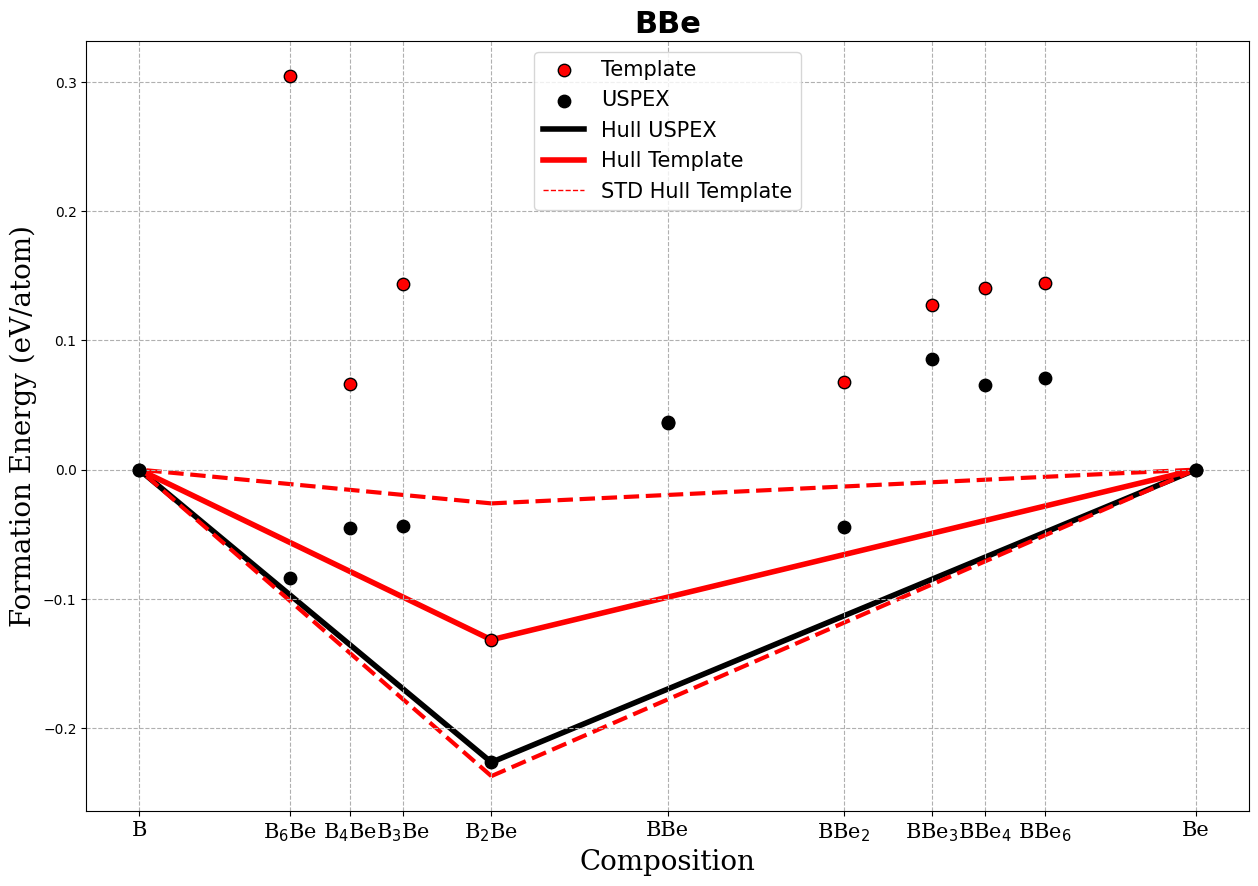

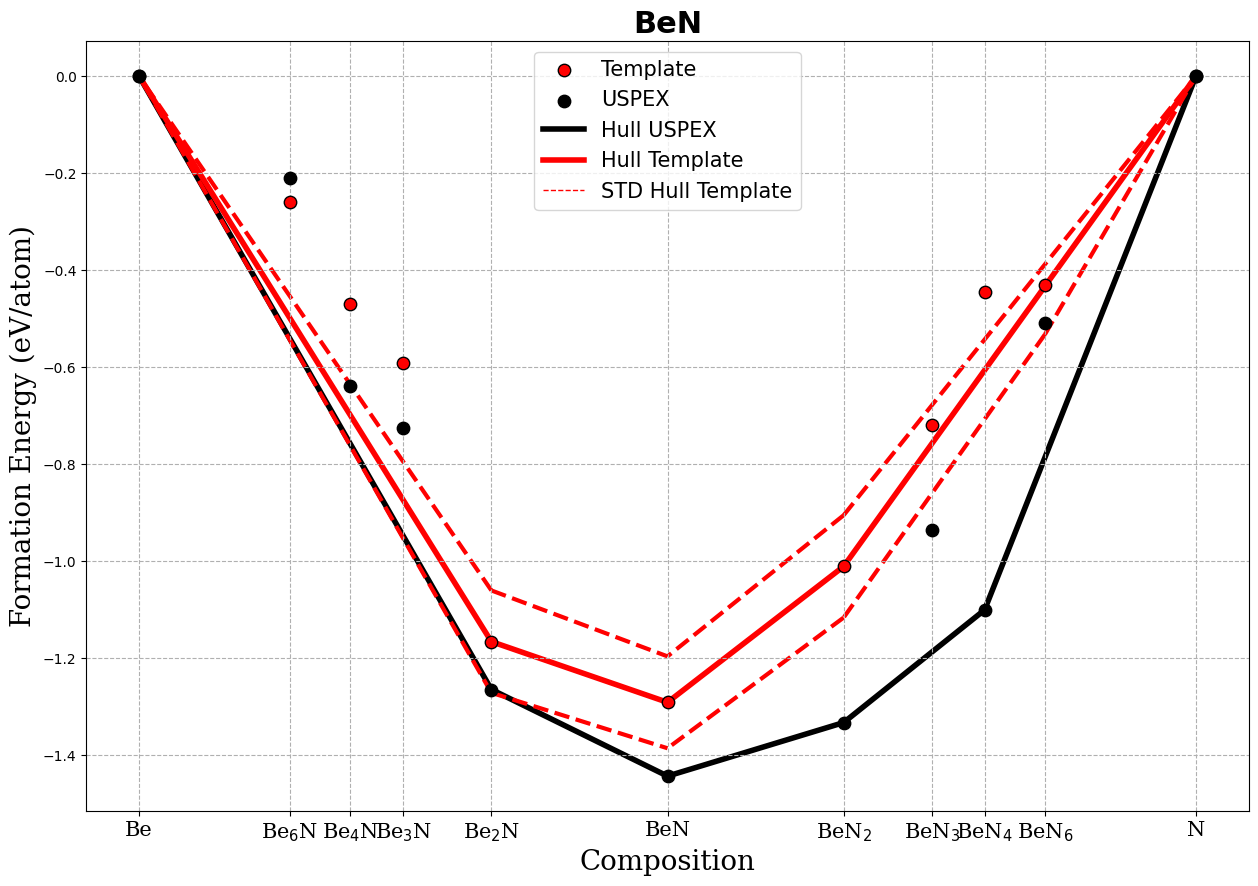

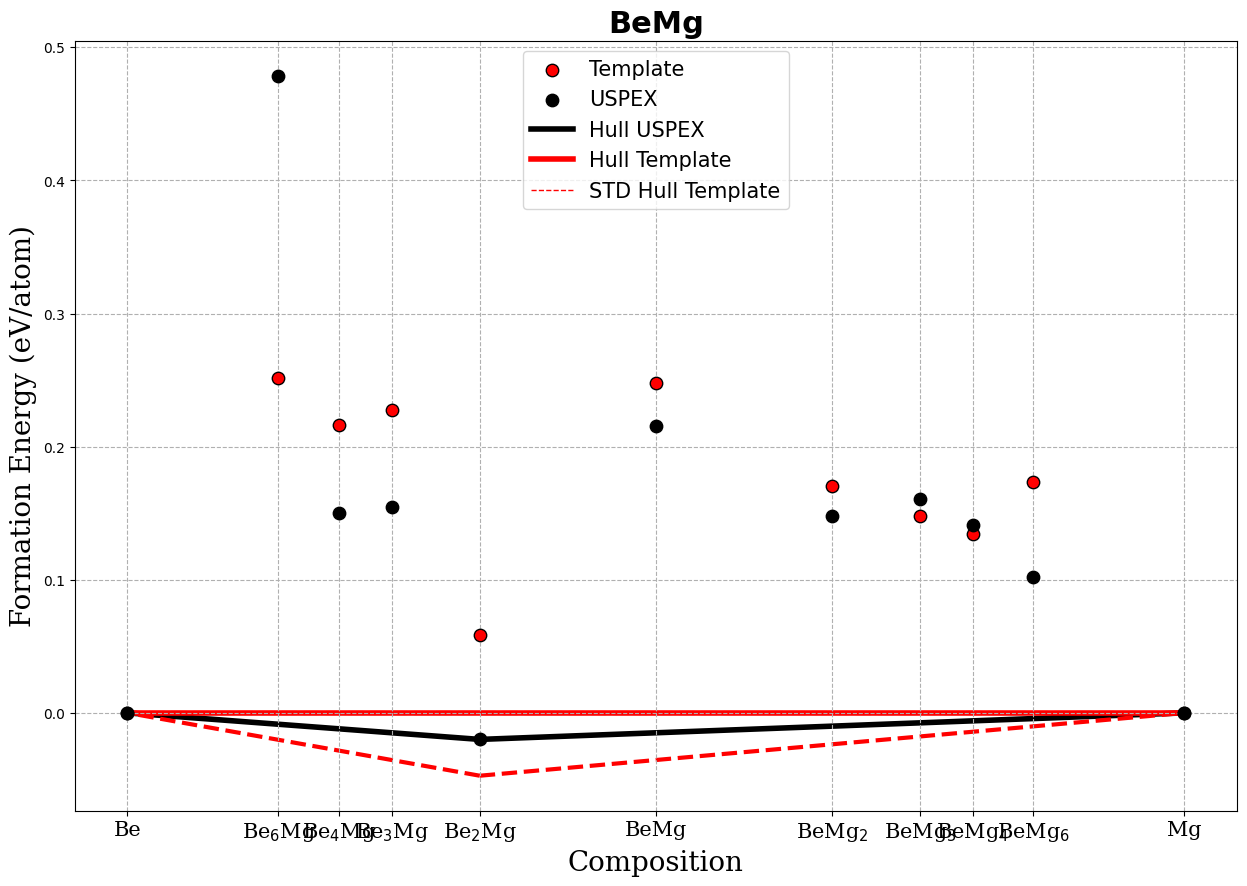

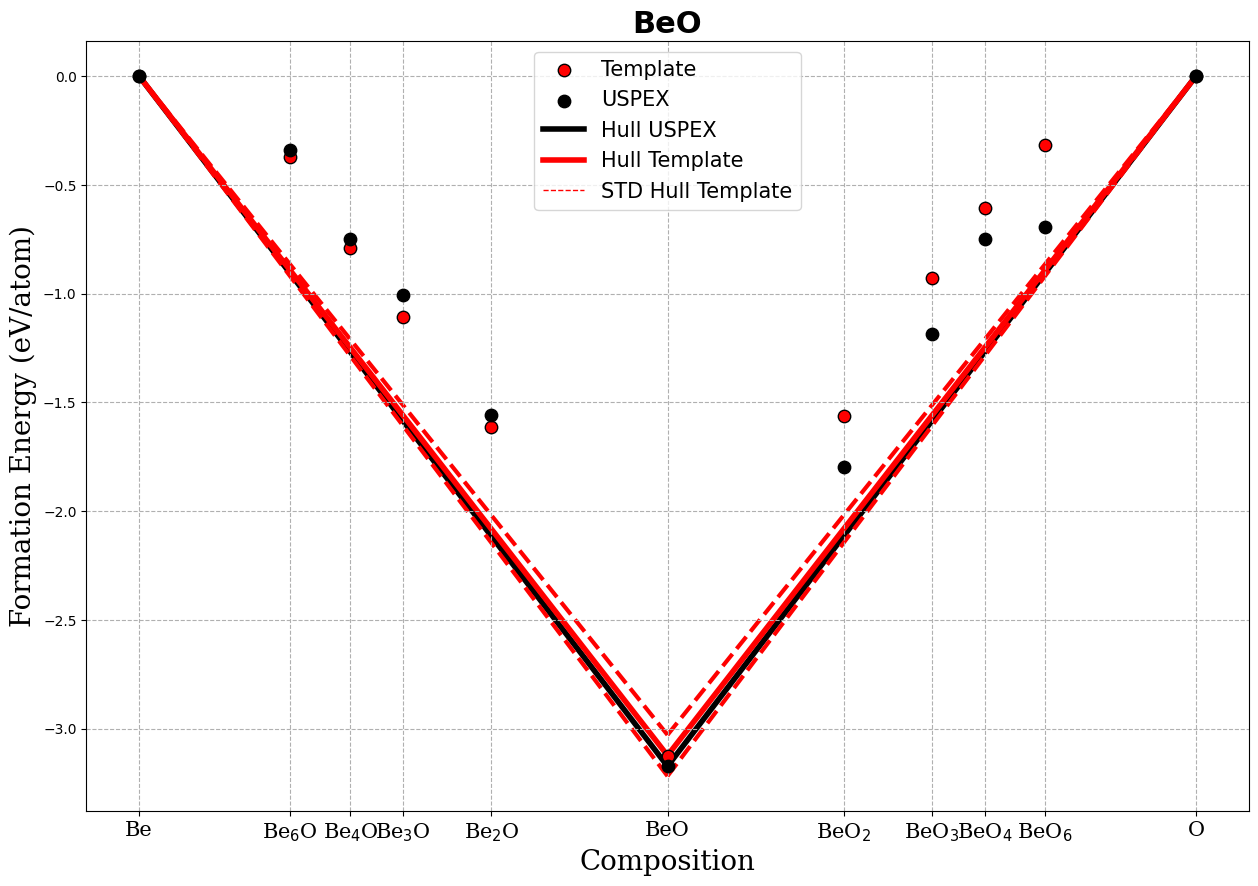

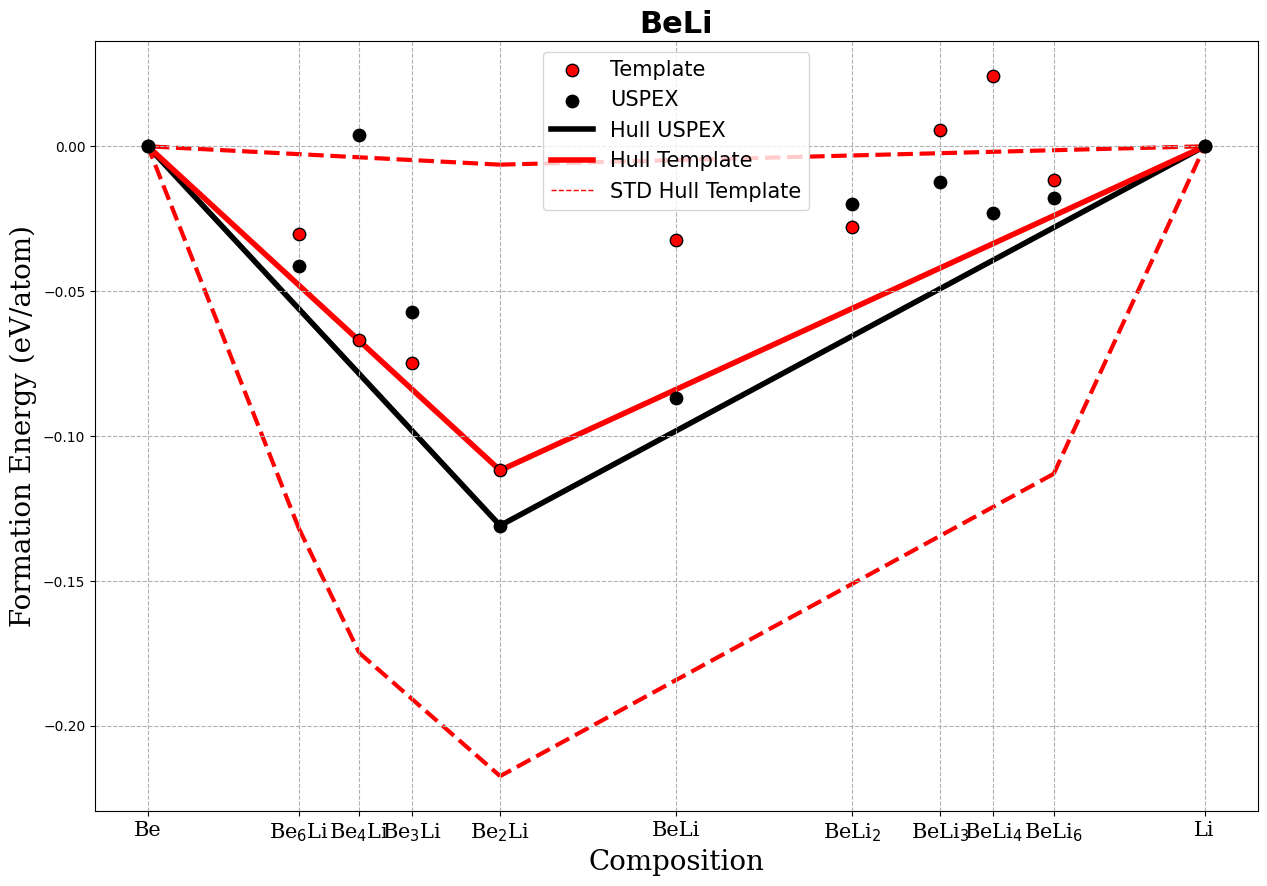

In [5]:
import matplotlib.pyplot as plt
import re
from scipy.spatial import ConvexHull
import numpy as np 
import json

# x = [0,1/5,1/4,1/3,1/2,2/3,3/4,4/5,1]
x = [0,1/7,1/5,1/4,1/3,1/2,2/3,3/4,4/5,6/7,1]

dir_dati = './DATA_DICT/'

with open(dir_dati + 'ConvexHulls_GS.json', 'r') as f:
    gs_hulls = json.load(f)

with open(dir_dati + 'ConvexHulls.json', 'r') as f:
    temp_hulls = json.load(f)

with open(dir_dati + 'ConvexHulls_std.json', 'r') as f:
    temp_hulls_std = json.load(f)

lista_pair = list(temp_hulls.keys())

prof = True

if prof == True:
    with open(dir_dati + 'ProfSTD.txt', 'r') as f:
        text = f.readlines()
    temp_hulls_std_prof = eval(text[0])

for i in range(5):
    A = re.search(r'([A-Z][a-z]*)([A-Z][a-z]*)', lista_pair[i]).group(1)
    B = re.search(r'([A-Z][a-z]*)([A-Z][a-z]*)', lista_pair[i]).group(2)
    fig, ax = plt.subplots(1,1, figsize=(15,10))
    ax.set_title(f'{lista_pair[i]}', fontsize=22, fontweight='bold')
    
    y_uspex = [j for j in gs_hulls[lista_pair[i]]]
    y_uspex.insert(0,0)
    y_uspex.append(0)
    y_temp = [j for j in temp_hulls[lista_pair[i]]]
    y_temp.insert(0,0)
    y_temp.append(0)
    
    if prof == False:
        y_std_max = [j+i for j, i in zip(temp_hulls_std[lista_pair[i]], temp_hulls[lista_pair[i]])]
        y_std_max.insert(0,0)
        y_std_max.append(0)
        y_std_min = [j-i for j, i in zip(temp_hulls[lista_pair[i]], temp_hulls_std[lista_pair[i]])]
        y_std_min.insert(0,0)
        y_std_min.append(0)
    else:
        y_std_max = [j+i for j, i in zip(temp_hulls_std_prof, temp_hulls[lista_pair[i]])]
        y_std_max.insert(0,0)
        y_std_max.append(0)
        y_std_min = [j-i for j, i in zip(temp_hulls[lista_pair[i]], temp_hulls_std_prof)]
        y_std_min.insert(0,0)
        y_std_min.append(0)

    points_temp = np.column_stack((x, y_temp))
    points_uspex = np.column_stack((x, y_uspex))
    points_temp_std_max = np.column_stack((x, y_std_max))
    points_temp_std_min = np.column_stack((x, y_std_min))

# Calcoliamo la convex hull
    hull_temp = ConvexHull(points_temp)
    hull_uspex = ConvexHull(points_uspex)
    hull_temp_std_max = ConvexHull(points_temp_std_max)
    hull_temp_std_min = ConvexHull(points_temp_std_min)

    hull_edges_us = []
    for simplex in hull_uspex.simplices:
        x1, y1 = points_uspex[simplex[0]]
        x2, y2 = points_uspex[simplex[1]]
        if y1 == 0 and y2 == 0:  # Consideriamo solo segmenti interamente sotto y = 0
            continue
        if y1 <= 0 and y2 <= 0:  # Consideriamo solo segmenti interamente sotto y = 0
            hull_edges_us.append((x1, y1, x2, y2))
    if len(hull_edges_us) == 0:
        hull_edges_us.append((0,0,1,0))
        
    hull_edges_temp = []
    for simplex in hull_temp.simplices:
        x1, y1 = points_temp[simplex[0]]
        x2, y2 = points_temp[simplex[1]]
        if y1 == 0 and y2 == 0:
            continue
        if y1 <= 0 and y2 <= 0:  # Consideriamo solo segmenti interamente sotto y = 0
            hull_edges_temp.append((x1, y1, x2, y2))
    if len(hull_edges_temp) == 0:
        hull_edges_temp.append((0,0,1,0))

    hull_edges_temp_std_max = []
    for simplex in hull_temp_std_max.simplices:
        x1, y1 = points_temp_std_max[simplex[0]]
        x2, y2 = points_temp_std_max[simplex[1]]
        if y1 == 0 and y2 == 0:
            continue
        if y1 <= 0 and y2 <= 0:  # Consideriamo solo segmenti interamente sotto y = 0
            hull_edges_temp_std_max.append((x1, y1, x2, y2))
    if len(hull_edges_temp_std_max) == 0:
        hull_edges_temp_std_max.append((0,0,1,0))

    hull_edges_temp_std_min = []
    for simplex in hull_temp_std_min.simplices:
        x1, y1 = points_temp_std_min[simplex[0]]
        x2, y2 = points_temp_std_min[simplex[1]]
        if y1 == 0 and y2 == 0:
            continue
        if y1 <= 0 and y2 <= 0:  # Consideriamo solo segmenti interamente sotto y = 0
            hull_edges_temp_std_min.append((x1, y1, x2, y2))
    if len(hull_edges_temp_std_min) == 0:
        hull_edges_temp_std_min.append((0,0,1,0))



    for x1, y1, x2, y2 in hull_edges_us:
        ax.plot([x1, x2], [y1, y2], 'k-', lw=4, zorder = 1)
    for x1, y1, x2, y2 in hull_edges_temp:
        ax.plot([x1, x2], [y1, y2], 'r-', lw=4, zorder = 1)
    
    for x1, y1, x2, y2 in hull_edges_temp_std_max:
        ax.plot([x1, x2], [y1, y2], 'r--', lw=3, zorder = 1)
    for x1, y1, x2, y2 in hull_edges_temp_std_min:
        ax.plot([x1, x2], [y1, y2], 'r--', lw=3, zorder = 1)

    ax.scatter(x, y_temp, label = 'Template', color = 'red' , marker = 'o', edgecolors='black', s = 80, zorder=2)
    ax.scatter(x, y_uspex, label = 'USPEX', color = 'black', marker = 'o', edgecolors = 'black', s = 80, zorder=2)

    ax.add_artist(plt.Line2D((0,0), (0,0), color='black', linewidth=4, label='Hull USPEX'))
    ax.add_artist(plt.Line2D((0,0), (0,0), color='red', linewidth=4, label='Hull Template'))
    ax.add_artist(plt.Line2D((0,0), (0,0), color='red', linestyle='--', linewidth=1, label='STD Hull Template'))


    ax.set_xticks(x)
    ax.set_xticklabels([A, f'{A}$_6${B}', f'{A}$_4${B}', f'{A}$_3${B}', f'{A}$_2${B}', f'{A}{B}', f'{A}{B}$_2$', f'{A}{B}$_3$', f'{A}{B}$_4$', f'{A}{B}$_6$', B], fontsize=15, family='serif')
    # ax.set_xticklabels([A, f'{A}$_4${B}', f'{A}$_3${B}', f'{A}$_2${B}', f'{A}{B}', f'{A}{B}$_2$', f'{A}{B}$_3$', f'{A}{B}$_4$',  B], fontsize=15, family='serif')


    ax.set_xlabel('Composition', fontsize=20, family='serif')
    ax.set_ylabel('Formation Energy (eV/atom)', fontsize=20, family='serif')
    ax.grid(True, linestyle='--')
    ax.legend(loc= 'upper center', fontsize=15)

#### HULL VECTOR

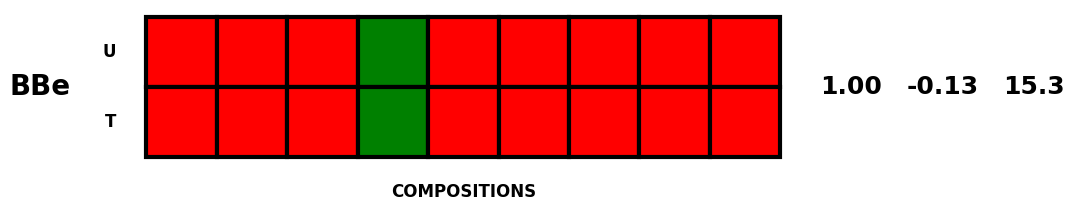

In [11]:
from scipy.spatial import ConvexHull
import numpy as np
from scipy.interpolate import interp1d
import json
import matplotlib.pyplot as plt

x = [0,1/7,1/5,1/4,1/3,1/2,2/3,3/4,4/5,6/7,1]


dir_dati = './DATA_DICT/'

with open(dir_dati + 'ConvexHulls_GS.json', 'r') as f:
    gs_hulls = json.load(f)

with open(dir_dati + 'ConvexHulls.json', 'r') as f:
    temp_hulls = json.load(f)

with open(dir_dati + 'ConvexHulls_std.json', 'r') as f:
    temp_hulls_std = json.load(f)

# pair = 'BeLi'

prof = True

no_std = True

if prof == True:
    with open(dir_dati + 'ProfSTD.txt', 'r') as f:
        text = f.readlines()
    temp_hulls_std_prof = eval(text[0])

lista_pair = list(temp_hulls.keys())

for idx_pair in range(1):
    y_uspex = [j for j in gs_hulls[lista_pair[idx_pair]]]
    y_uspex.insert(0,0)
    y_uspex.append(0)
    y_temp = [j for j in temp_hulls[lista_pair[idx_pair]]]
    y_temp.insert(0,0)
    y_temp.append(0)

    if no_std == True:
        y_std_max = y_temp
        y_std_min = y_temp
    
    else:
        if prof == False:
            y_std_max = [j+i for j, i in zip(temp_hulls_std[lista_pair[idx_pair]], temp_hulls[lista_pair[idx_pair]])]
            y_std_max.insert(0,0)
            y_std_max.append(0)
            y_std_min = [j-i for j, i in zip(temp_hulls[lista_pair[idx_pair]], temp_hulls_std[lista_pair[idx_pair]])]
            y_std_min.insert(0,0)
            y_std_min.append(0)
        else:
            y_std_max = [j+i for j, i in zip(temp_hulls_std_prof, temp_hulls[lista_pair[idx_pair]])]
            y_std_max.insert(0,0)
            y_std_max.append(0)
            y_std_min = [j-i for j, i in zip(temp_hulls[lista_pair[idx_pair]], temp_hulls_std_prof)]
            y_std_min.insert(0,0)
            y_std_min.append(0)

    points_uspex = np.column_stack((x, y_uspex))
    points_temp_std_max = np.column_stack((x, y_std_max))
    points_temp_std_min = np.column_stack((x, y_std_min))

    # Calcoliamo la convex hull
    hull_uspex = ConvexHull(points_uspex)
    hull_temp_std_max = ConvexHull(points_temp_std_max)
    hull_temp_std_min = ConvexHull(points_temp_std_min)

    ### VETTORE HULL DI USPEX
    vector_uspex = [0 for i in x]
    vector_uspex[0] = 1
    vector_uspex[-1] = 1
    for simplex in hull_uspex.simplices:
        x1, y1 = points_uspex[simplex[0]]
        x2, y2 = points_uspex[simplex[1]]
        if y1 == 0 and y2 == 0:  # Consideriamo solo segmenti interamente sotto y = 0
            continue
        if y1 <= 0 and y2 <= 0:  # Consideriamo solo segmenti interamente sotto y = 0
            vector_uspex[x.index(x1)] = 1
            vector_uspex[x.index(x2)] = 1


    ### UPPER LIMIT HULL TEMP
    upper_limit_x = []
    upper_limit_y = []
    for simplex in hull_temp_std_max.simplices:
        x1, y1 = points_temp_std_max[simplex[0]]
        x2, y2 = points_temp_std_max[simplex[1]]
        if y1 == 0 and y2 == 0:
            continue
        if y1 <= 0 and y2 <= 0:  # Consideriamo solo segmenti interamente sotto y = 0
            if x1 not in upper_limit_x:
                upper_limit_x.append(x1)
                upper_limit_y.append(y1)
            if x2 not in upper_limit_x:
                upper_limit_x.append(x2)
                upper_limit_y.append(y2)
    if len(upper_limit_x) == 0:
        upper_limit_x.append(0)
        upper_limit_y.append(0)
        upper_limit_x.append(1)
        upper_limit_y.append(0)
    upper_limit_x = np.array(upper_limit_x)
    upper_limit_y = np.array(upper_limit_y)
    upper_limit_y = upper_limit_y[upper_limit_x.argsort()]
    upper_limit_x = upper_limit_x[upper_limit_x.argsort()]

    ### LOWER LIMIT HULL TEMP
    lower_limit_x = []
    lower_limit_y = []
    for simplex in hull_temp_std_min.simplices:
        x1, y1 = points_temp_std_min[simplex[0]]
        x2, y2 = points_temp_std_min[simplex[1]]
        if y1 == 0 and y2 == 0:
            continue
        if y1 <= 0 and y2 <= 0:  # Consideriamo solo segmenti interamente sotto y = 0
            if x1 not in lower_limit_x:
                lower_limit_x.append(x1)
                lower_limit_y.append(y1)
            if x2 not in lower_limit_x:
                lower_limit_x.append(x2)
                lower_limit_y.append(y2)
    if len(lower_limit_x) == 0:
        lower_limit_x.append(0)
        lower_limit_y.append(0)
        lower_limit_x.append(1)
        lower_limit_y.append(0)
        
    lower_limit_x = np.array(lower_limit_x)
    lower_limit_y = np.array(lower_limit_y)
    lower_limit_y = lower_limit_y[lower_limit_x.argsort()]
    lower_limit_x = lower_limit_x[lower_limit_x.argsort()]

    ### TEMP HULL VECTOR IF BETWEEN UPPER AND LOWER LIMIT    
    vector_temp = [0 for i in x]

    interpol_upper = interp1d(upper_limit_x, upper_limit_y, kind='linear', fill_value='extrapolate')
    interpol_lower = interp1d(lower_limit_x, lower_limit_y, kind='linear', fill_value='extrapolate')

    upper_interpol = interpol_upper(x)
    lower_interpol = interpol_lower(x)


    for i, comp in enumerate(x):
        up = upper_interpol[i]
        low = lower_interpol[i]

        if y_temp[i] <= up and y_temp[i] >= low:
            vector_temp[i] = 1
        else:
            vector_temp[i] = 0

    vector_temp = np.array(vector_temp[1:-1])
    if np.linalg.norm(vector_temp) != 0:
        vector_temp = vector_temp / np.linalg.norm(vector_temp)
    vector_uspex = np.array(vector_uspex[1:-1])
    if np.linalg.norm(vector_uspex) != 0:
        vector_uspex = vector_uspex / np.linalg.norm(vector_uspex)

    scalar_product = np.dot(vector_temp, vector_uspex)
    arcosine = np.arccos(scalar_product)

    n = len(vector_temp)  # Numero di elementi nella lista

    fig, ax = plt.subplots(figsize=(n + 3, 2))  # Definiamo la figura
    # Disegniamo i quadrati per gli 0 e 1
    for i, val in enumerate(vector_uspex):
        color = 'green' if val > 0 else 'red'  # Rosso per 1, Verde per 0
        ax.add_patch(plt.Rectangle((i, 1), 1, 1, edgecolor='black', facecolor=color, lw = 3))
    for i, val in enumerate(vector_temp):
        color = 'green' if val > 0  else 'red'  # Rosso per 1, Verde per 0
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, edgecolor='black', facecolor=color, lw = 3))

    # Quadrato per il nome della lista
    ax.text(-1.5, 1, lista_pair[idx_pair], ha='center', va='center', fontsize=20, fontweight='bold')

    # Quadrato per il valore associato
    ax.text(n + 1, 1, f'{scalar_product:.2f}', ha='center', va='center', fontsize=18, fontweight='bold')

    ax.text(n + 2.3, 1, f'{min(y_temp):.2f}', ha='center', va='center', fontsize=18, fontweight='bold')

    ax.text(n + 3.6, 1, '15.3', ha='center', va='center', fontsize=18, fontweight='bold')
    
    ax.text(-0.5 , 0.5, 'T', ha='center', va='center', fontsize=12, fontweight='bold' ) 
    ax.text(-0.52 , 1.5, 'U', ha='center', va='center', fontsize=12, fontweight='bold' )

    ax.text(4.5, -0.5, 'COMPOSITIONS', ha='center', va='center', fontsize=12, fontweight='bold')

    
    # Impostazioni dell'asse
    ax.set_xlim(-0.1, n + 4.1)
    ax.set_ylim(-0.1, 2.1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
plt.show()
